In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import basename
from glob import glob

%matplotlib inline

from ultralytics import YOLO
from matplotlib.colors import Normalize, ListedColormap

from src.load_from_raw import adjust_contrast
from src.evaluate import get_mask_from_gt, visualise

In [2]:
test_paths = glob("data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_big_labels/test/images/*")
test_full_images = set(basename(img_path).split("_")[0] for img_path in test_paths)

test_paths = glob("data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_small_labels/test/images/*")
test_patches_images = list(set(basename(img_path).split("_")[0] for img_path in test_paths))

list(test_full_images.intersection(test_patches_images))

['009-9703', '007-0137', '007-0258', '010-0896']

In [3]:
N_ROWS_PATCH = 8
N_COLS_PATCH = 8

PATH_DATASET_PATCH_IMAGES = "data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_small_labels/test/images"
PATH_DATASET_FULL_IMAGES = "data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_big_labels/test/images"
PATH_DATASET_SINGLE = "data/data_labeled/ctrst-0-255_srfc-0_prcs-0_seg"

PATH_MODEL_FULL = "runs/segmentation/yolo11n_ctrst-0-255_srfc-200_prcs-0_seg_big_labels_epochs-100_imgsz-1520_batch-8/weights/best.pt"
PATH_MODEL_PATCH = "runs/segmentation/yolo11n_ctrst-0-255_srfc-200_prcs-0_seg_small_labels_epochs-100_imgsz-190_batch-8/weights/best.pt"
PATH_SINGLE_MODEL = "runs/segmentation/yolo11n_ctrst-0-255_srfc-0_prcs_0_seg_single_model_epochs-100_imgsz-1616_batch-8/weights/best.pt"

img_name = '008-2980'

In [4]:
interactive_plot, img_mask, img, combined_slices, combined_images  = visualise("009-9703", True, PATH_DATASET_PATCH_IMAGES, PATH_DATASET_FULL_IMAGES, PATH_MODEL_FULL, PATH_MODEL_PATCH, True, N_ROWS_PATCH, N_COLS_PATCH)

101it [03:34,  2.12s/it]
100%|██████████| 315/315 [03:17<00:00,  1.60it/s]


In [5]:
interactive_plot

interactive(children=(IntSlider(value=0, description='Slice:'), IntSlider(value=0, description='Min Contrast:'…

In [144]:
viridis_cmap = plt.cm.viridis
new_colors = viridis_cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]
custom_cmap = ListedColormap(new_colors)
norm = Normalize(vmin=1, vmax=101)

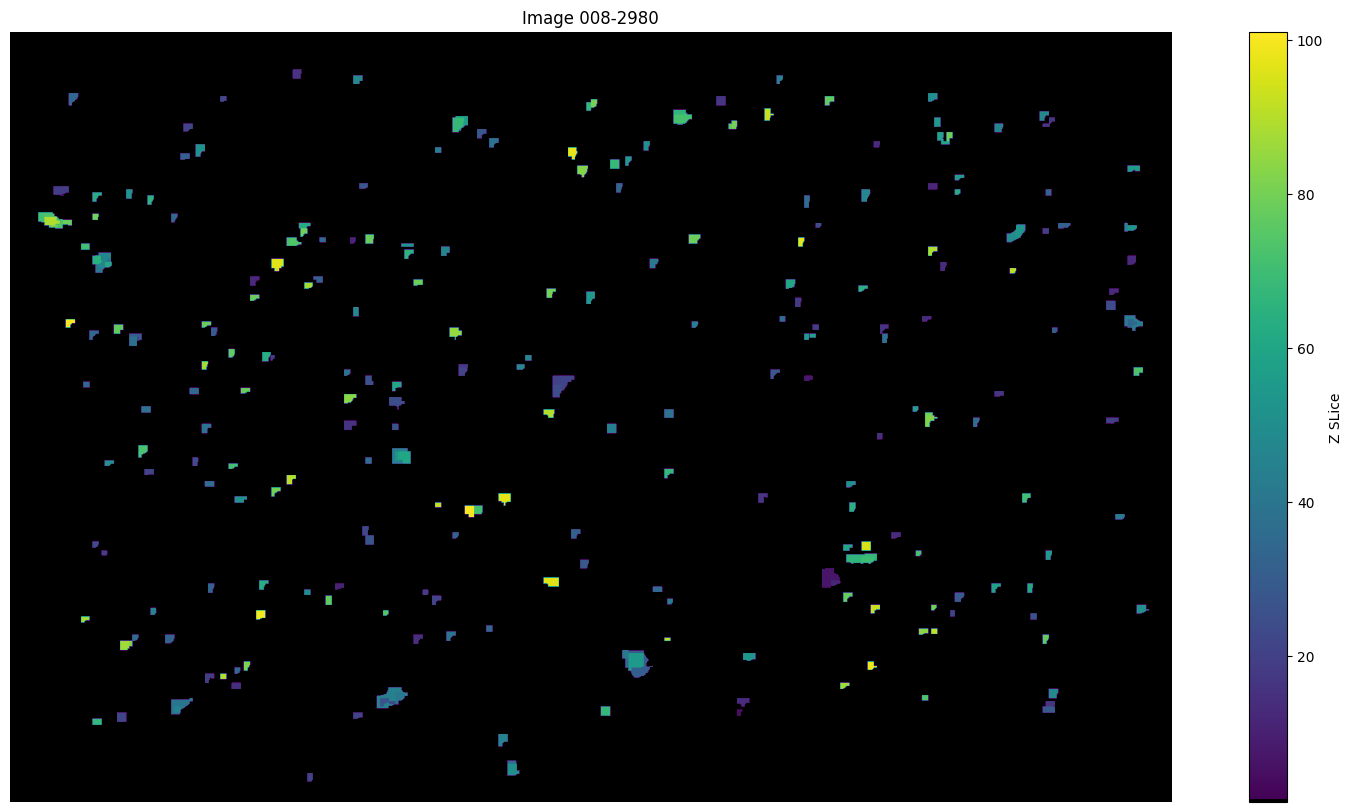

In [145]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name}")
plt.imshow(combined_slices, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

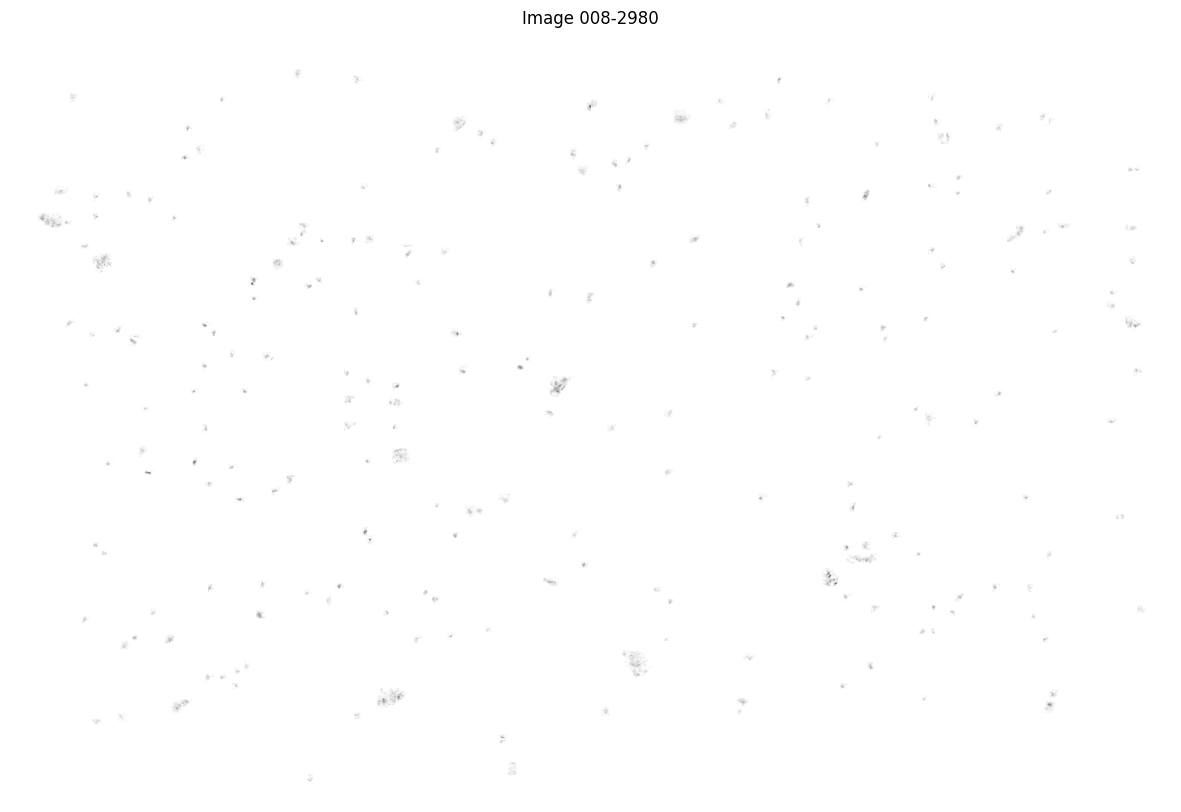

In [146]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name}")
plt.imshow(combined_images, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()

______

## Validation

Try computing dice by first concatenating ground truth and prediction arrays, find connected components that are spanning across 2 slices (find corresponding predictions) and compute the dice on those

In [8]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from os.path import join, basename, dirname, exists
from scipy.ndimage import label
import matplotlib.pyplot as plt
import tifffile as tiff
from src.evaluate import evaluate_final_output

In [9]:
TEST_FOLDER_PATH_SMALL = "data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_small_labels/test"
TEST_FOLDER_PATH_BIG = "data/data_split/ctrst-0-255_srfc-200_prcs-0_seg_big_labels/test"

labeled_folder_path = "data/data_labeled/ctrst-0-255_srfc-200_prcs-0_seg"

images_small = set([basename(file_path).split("_")[0] for file_path in glob(join(TEST_FOLDER_PATH_SMALL,"images","*.jpg"))])
images_big = set([basename(file_path).split("_")[0] for file_path in glob(join(TEST_FOLDER_PATH_BIG,"images","*.jpg"))])

images = list(images_small.union(images_big))

In [ ]:
test_tp_old = 0
test_fp_old = 0
test_fn_old = 0
best_dices_old = []
best_dices_non_zero_old = []
sizes_old = []
sizes_nonzero_old = []
test_tp_single = 0
test_fp_single = 0
test_fn_single = 0
best_dices_single = []
best_dices_non_zero_single = []
sizes_single = []
sizes_nonzero_single = []
test_tp_new = 0
test_fp_new = 0
test_fn_new = 0
best_dices_new = []
best_dices_non_zero_new = []
sizes_new = []
sizes_nonzero_new = []

# Iterate through the images of the test set
for img_name in images:
    # Get the mask from the ground truth
    mask_gt = get_mask_from_gt(labeled_folder_path, img_name)
    # Get the mask from the original model
    img_stack = tiff.imread(f"dep_files/{img_name}-dep.tiff")
    gray_image = cv2.cvtColor(img_stack, cv2.COLOR_BGR2GRAY)
    cropped_gray_image = gray_image[95:-167, 39:-57]
    _, mask_previous_model = cv2.threshold(
                cropped_gray_image.astype(np.uint8),
                0,
                255,
                cv2.THRESH_BINARY + cv2.THRESH_OTSU,
            )
    # Get the mask from the combined model
    _, _, _, combined_slices, combined_images = visualise(img_name, True, PATH_DATASET_PATCH_IMAGES, PATH_DATASET_FULL_IMAGES, PATH_MODEL_FULL, PATH_MODEL_PATCH, True)
    # Get the mask from the single model
    _, _, _, combined_slices_single_model, _ = visualise(img_name, True, None, PATH_DATASET_SINGLE, PATH_SINGLE_MODEL, None, False)

    # Evaluate the original model's mask
    perf_dict_old = evaluate_final_output(mask_gt, mask_previous_model)
    test_tp_old += perf_dict_old["true_positive"]
    test_fp_old += perf_dict_old["false_positive"]
    test_fn_old += perf_dict_old["false_negative"]
    best_dices_old += perf_dict_old["best_dices"]
    best_dices_non_zero_old += perf_dict_old["best_dices_non_zero"]
    sizes_old += perf_dict_old["sizes"]
    sizes_nonzero_old += perf_dict_old["sizes_nonzero"]

    # Evaluate the single model's mask
    perf_dict_single = evaluate_final_output(mask_gt, combined_slices_single_model[95:-137, 39:-57])
    test_tp_single += perf_dict_single["true_positive"]
    test_fp_single += perf_dict_single["false_positive"]
    test_fn_single += perf_dict_single["false_negative"]
    best_dices_single += perf_dict_single["best_dices"]
    best_dices_non_zero_single += perf_dict_single["best_dices_non_zero"]
    sizes_single += perf_dict_single["sizes"]
    sizes_nonzero_single += perf_dict_single["sizes_nonzero"]

    # Evaluate the combined model's mask
    perf_dict_new = evaluate_final_output(mask_gt, np.where(combined_slices > 0, 1, 0))
    test_tp_new += perf_dict_new["true_positive"]
    test_fp_new += perf_dict_new["false_positive"]
    test_fn_new += perf_dict_new["false_negative"]
    best_dices_new += perf_dict_new["best_dices"]
    best_dices_non_zero_new += perf_dict_new["best_dices_non_zero"]
    sizes_new += perf_dict_new["sizes"]
    sizes_nonzero_new += perf_dict_new["sizes_nonzero"]

    # Output the performances of each model for the current image
    print(f"For image {img_name}:")
    for key in perf_dict_new.keys():
        if key not in ["best_dices","best_dices_non_zero","sizes","sizes_nonzero"]:
            print(f"{key} : {round(perf_dict_old[key],2)} for old model, {round(perf_dict_single[key],2)} for single model, {round(perf_dict_new[key],2)} for combined model")
    print("")
# Compute the final performances on the test set
test_recall_old = test_tp_old/(test_tp_old+test_fn_old)
test_precision_old = test_tp_old/(test_tp_old+test_fp_old)
test_f1_score_old = 2*test_recall_old*test_precision_old/(test_recall_old+test_precision_old)
test_mDice_old = np.mean(best_dices_old)
test_mDice_non_zero_old = np.mean(best_dices_non_zero_old)
test_weighted_mDice_old = np.sum([sizes_old[i]*best_dices_old[i] for i in range(len(sizes_old))]) / np.sum(sizes_old)
test_weighted_mDice_non_zero_old = np.sum([sizes_nonzero_old[i]*best_dices_non_zero_old[i] for i in range(len(best_dices_non_zero_old))]) / np.sum(sizes_nonzero_old)

test_recall_single = test_tp_single/(test_tp_single+test_fn_single)
test_precision_single = test_tp_single/(test_tp_single+test_fp_single)
test_f1_score_single = 2*test_recall_single*test_precision_single/(test_recall_single+test_precision_single)
test_mDice_single = np.mean(best_dices_single)
test_mDice_non_zero_single = np.mean(best_dices_non_zero_single)
test_weighted_mDice_single = np.sum([sizes_single[i]*best_dices_single[i] for i in range(len(sizes_single))]) / np.sum(sizes_single)
test_weighted_mDice_non_zero_single = np.sum([sizes_nonzero_single[i]*best_dices_non_zero_single[i] for i in range(len(best_dices_non_zero_single))]) / np.sum(sizes_nonzero_single)

test_recall_new = test_tp_new/(test_tp_new+test_fn_new)
test_precision_new = test_tp_new/(test_tp_new+test_fp_new)
test_f1_score_new = 2*test_recall_new*test_precision_new/(test_recall_new+test_precision_new)
test_mDice_new = np.mean(best_dices_new)
test_mDice_non_zero_new = np.mean(best_dices_non_zero_new)
test_weighted_mDice_new = np.sum([sizes_new[i]*best_dices_new[i] for i in range(len(sizes_new))]) / np.sum(sizes_new)
test_weighted_mDice_non_zero_new = np.sum([sizes_nonzero_new[i]*best_dices_non_zero_new[i] for i in range(len(best_dices_non_zero_new))]) / np.sum(sizes_nonzero_new)

# Output the final performances on the test set
print("On test set:")
print(f"True Positives : {round(test_tp_old,2)} for old model, {round(test_tp_single,2)} for single model and {round(test_tp_new,2)} for combined model")
print(f"False Positives : {round(test_fp_old,2)} for old model, {round(test_fp_single,2)} for single model and {round(test_fp_new,2)} for combined model")
print(f"False Negatives : {round(test_fn_old,2)} for old model, {round(test_fn_single,2)} for single model and {round(test_fn_new,2)} for combined model")
print(f"Recall : {round(test_recall_old,2)} for old model, {round(test_recall_single,2)} for single model and {round(test_recall_new,2)} for combined model")
print(f"Precision : {round(test_precision_old,2)} for old model, {round(test_precision_single,2)} for single model and {round(test_precision_new,2)} for combined model")
print(f"F1-Score : {round(test_f1_score_old,2)} for old model, {round(test_f1_score_single,2)} for single model and {round(test_f1_score_new,2)} for combined model")
print(f"mDice : {round(test_mDice_old,2)} for old model, {round(test_mDice_single,2)} for single model and {round(test_mDice_new,2)} for combined model")
print(f"mDice_nonzero : {round(test_mDice_non_zero_old,2)} for old model, {round(test_mDice_non_zero_single,2)} for single model and {round(test_mDice_non_zero_new,2)} for combined model")
print(f"weighted_mDice : {round(test_weighted_mDice_old,2)} for old model, {round(test_weighted_mDice_single,2)} for single model and {round(test_weighted_mDice_new,2)} for combined model")
print(f"weighted_mDice_nonzero : {round(test_weighted_mDice_non_zero_old,2)} for old model, {round(test_weighted_mDice_non_zero_single,2)} for single model and {round(test_weighted_mDice_non_zero_new,2)} for combined model")

In [117]:
viridis_cmap = plt.cm.viridis
new_colors = viridis_cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]
custom_cmap = ListedColormap(new_colors)
norm = Normalize(vmin=1, vmax=101)

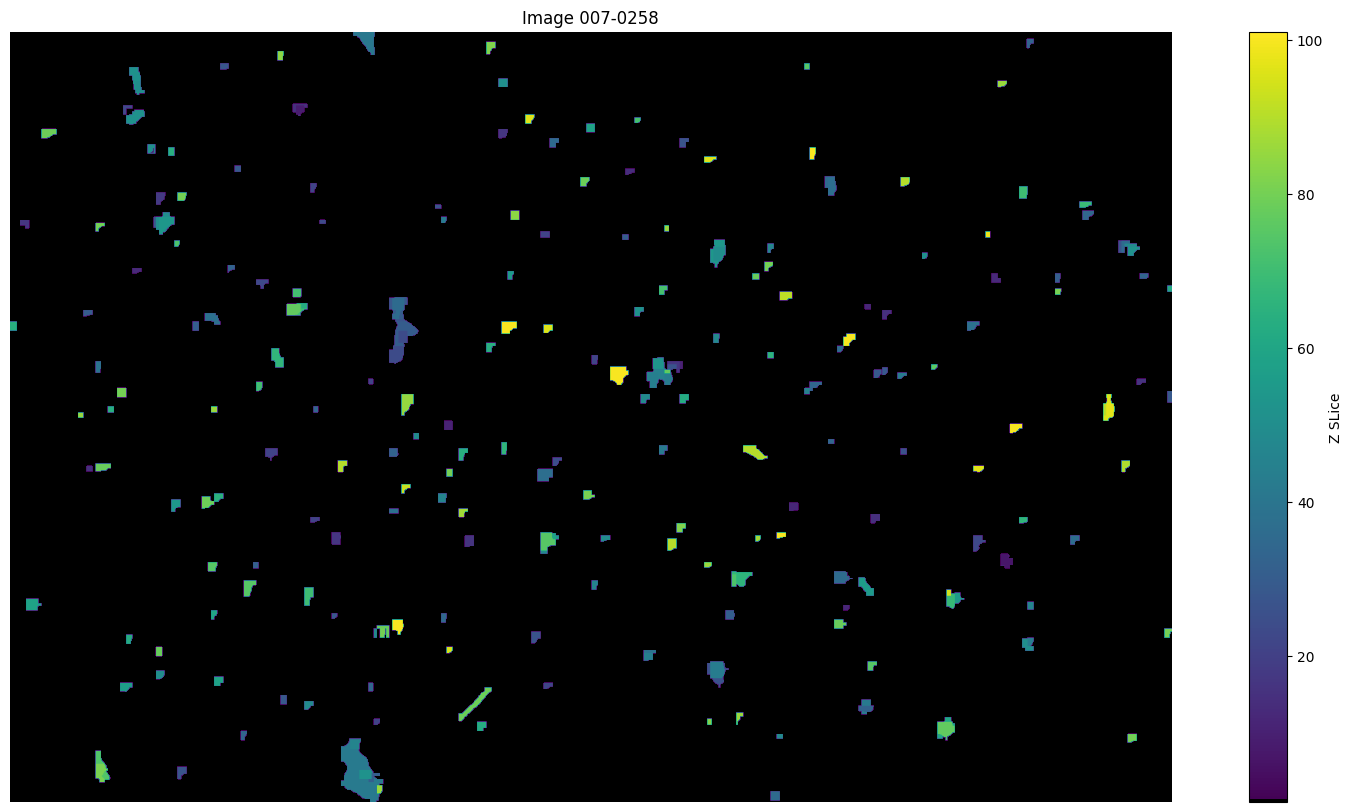

In [119]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name} | Combined Model's Masks")
plt.imshow(combined_slices, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

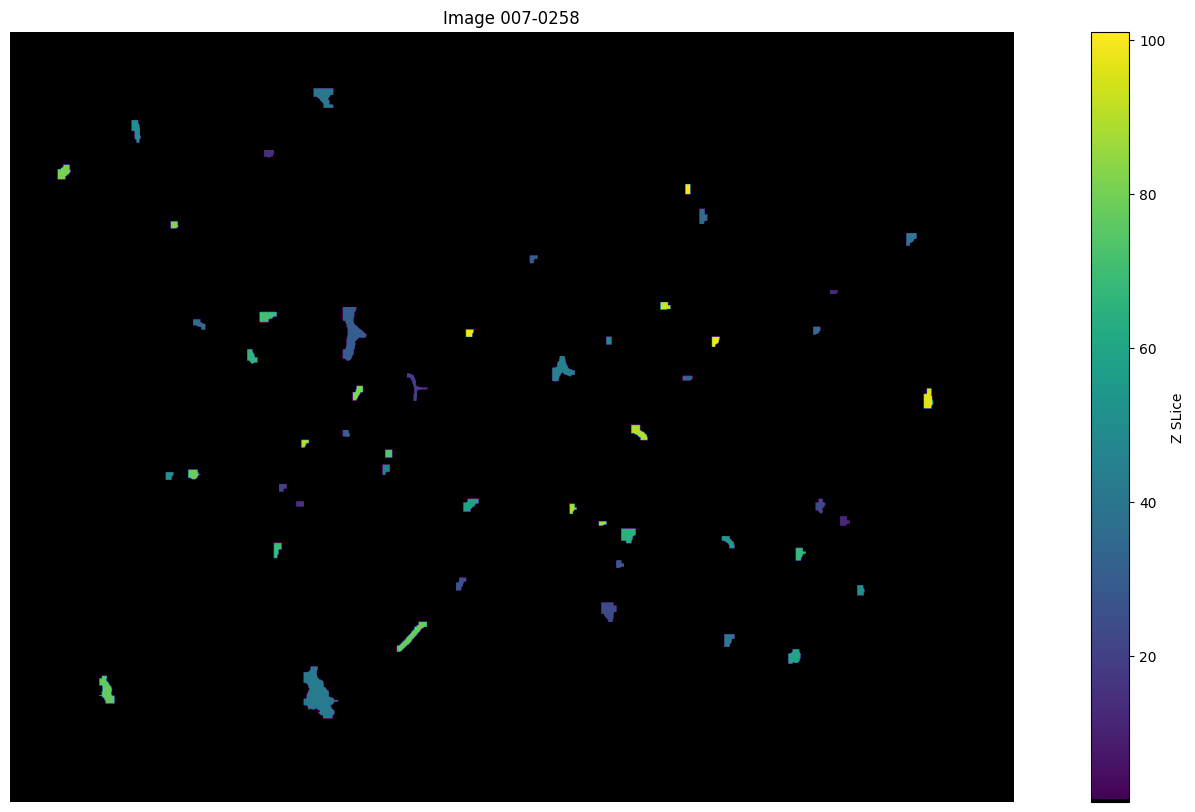

In [120]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name} | Single Model's Masks")
plt.imshow(combined_slices_single_model, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

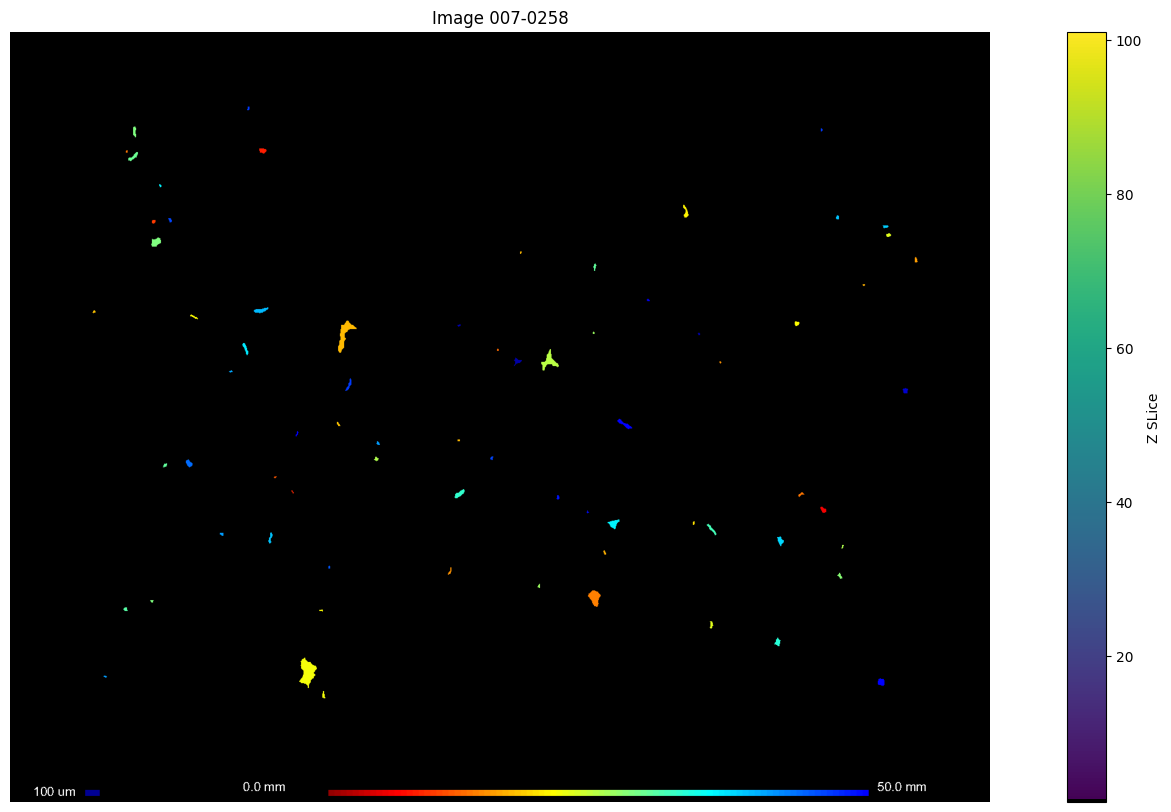

In [121]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name} | Original Model's Masks")
plt.imshow(img_stack, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

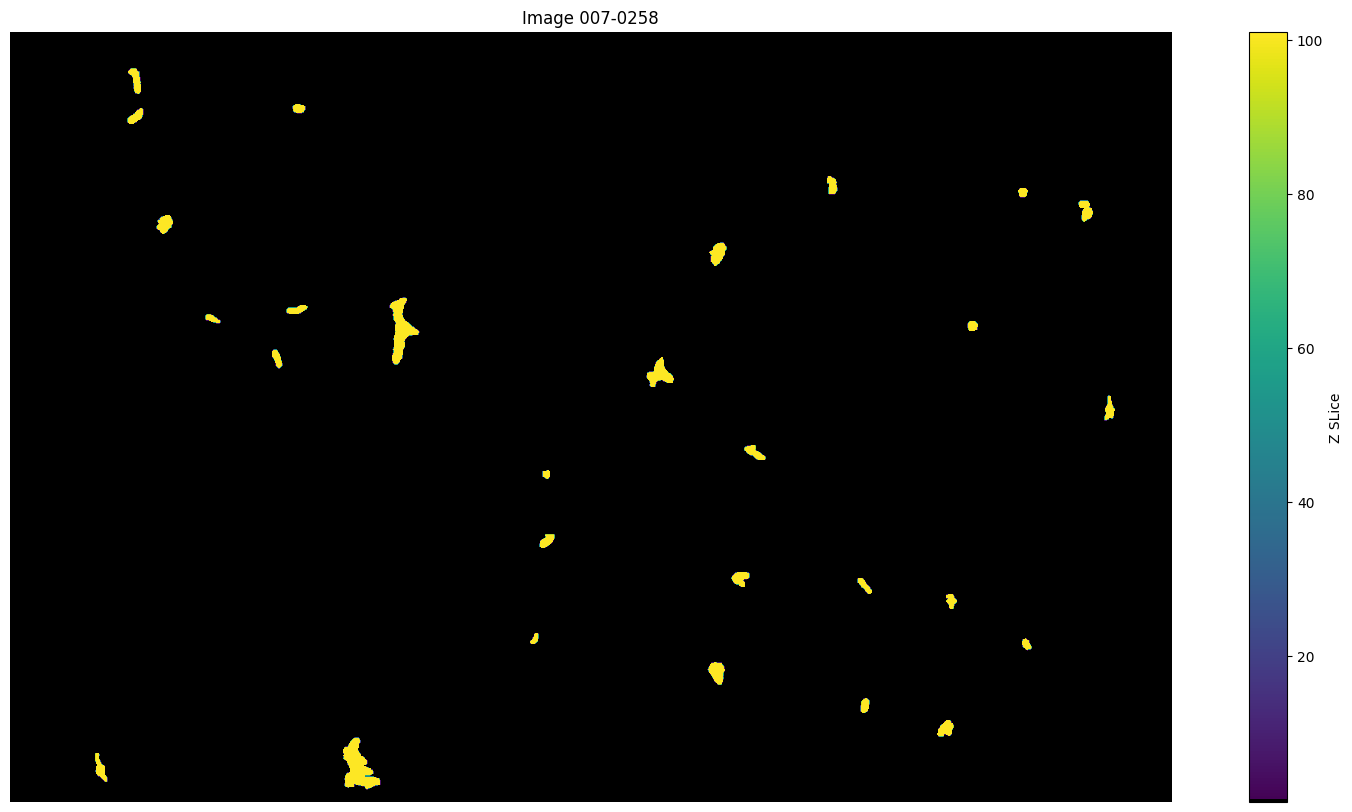

In [122]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name} | Original Label")
plt.imshow(mask_gt, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

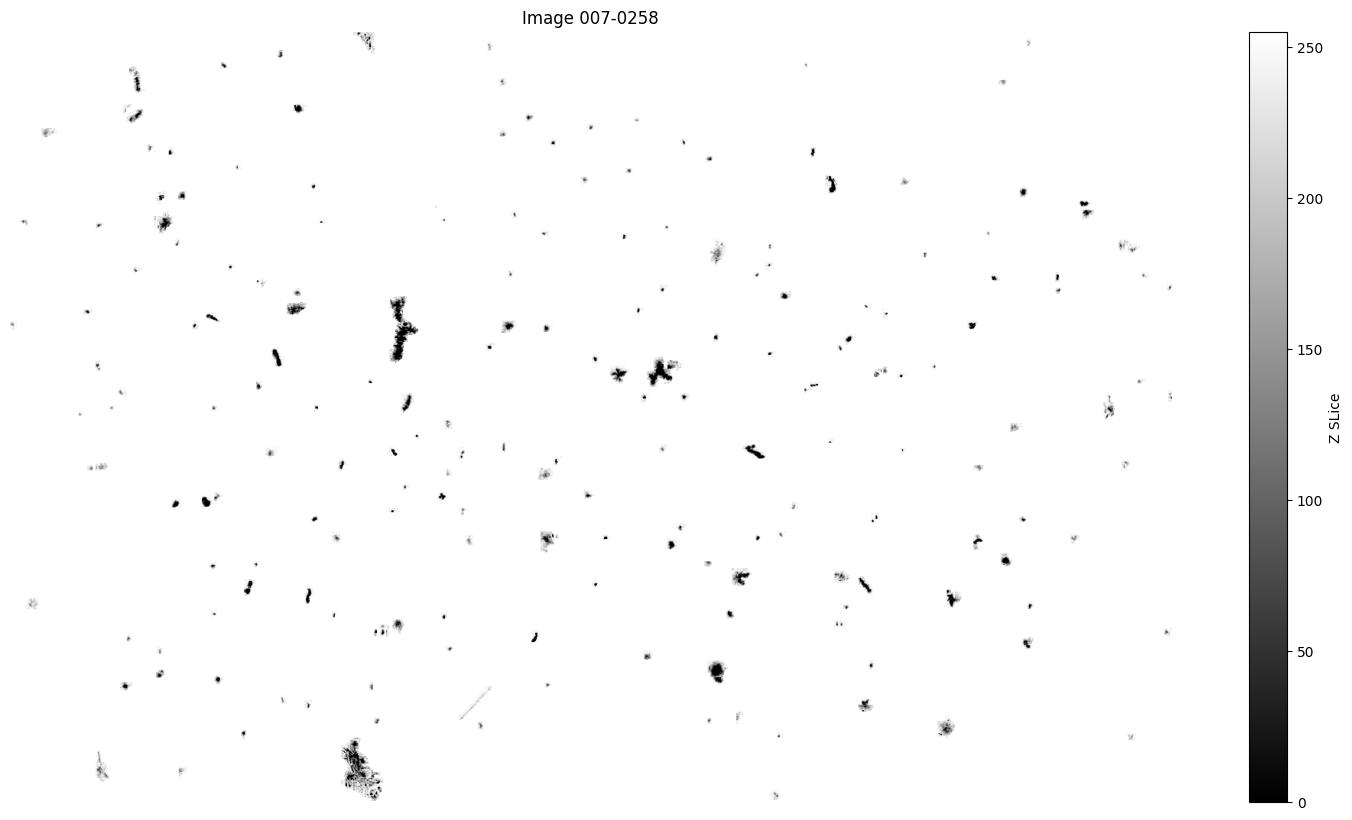

In [ ]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name} | Combined Model's Segmented Image")
plt.imshow(adjust_contrast(combined_images,210,255), cmap="gray")
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()